# Tx Tracker
This is an Application which will display you the big transaction between CEX during the last month

## 1. Imports

In [ ]:
import csv
import numpy as np
import tweepy
import graphviz
import pandas as p
from datetime import datetime

## 2. Settings

In [ ]:
bearer_token = "AAAAAAAAAAAAAAAAAAAAAN5SkwEAAAAAfQmavWns25LfpH6H7zolnXOhMVw%3DqmsCC0hz6DDNWd0Pr41S1G6PCnSjmgaR7jHHdIDbPjLRETp5dP"
username = "whale_alert"
csv_file = "Tx.csv"
with open(csv_file, 'w') as w_file:
    writer = csv.writer(w_file)
    writer.writerows([["date","amount","from","to"]])
limit_date = "2022-12-01"

## 3. Data Collection and storing in CSV

- Connecting to Twitter API

In [ ]:
auth = tweepy.OAuth2BearerHandler(bearer_token)
api = tweepy.API(auth)

- Defining methods for different types of Tweets (i.e. transactions, minting, burning, appending to csv file)

In [ ]:
def csv_append(date,amount,from_wallet,to_wallet):
    with open(csv_file, 'a') as a_file:
        writer_append = csv.writer(a_file)
        writer_append.writerow([date,amount,from_wallet,to_wallet])

def transaction(status):
    date = status.created_at
    text = status.text
    
    text = text.replace(",","")
    text = text.replace("#","")
    
    date = date.date()
    print(text.split("(")[1].split(" USD")[0])
    amount = int(text.split("(")[1].split(" USD")[0])
    from_wallet = text.split("from ")[1].split(" to")[0]
    to_wallet = text.split("to ")[1].split("\n")[0]

    csv_append(date,amount,from_wallet,to_wallet)

def burning(status):
    date = status.created_at
    text = status.text
    
    text = text.replace(",","")
    text = text.replace("#","")
    
    date = date.date()
    amount = -int(text.split("(")[1].split(" USD")[0])
    from_wallet = text.split("at ")[1].split("\n")[0]
    to_wallet = "Burn"

    csv_append(date,amount,from_wallet,to_wallet)

def minting(status):
    date = status.created_at
    text = status.text
    
    text = text.replace(",","")
    text = text.replace("#","")
    
    date = date.date()
    amount = int(text.split("(")[1].split(" USD")[0])
    from_wallet = text.split("at ")[1].split("\n")[0]
    to_wallet = "Mint"

    csv_append(date,amount,from_wallet,to_wallet)

- Then parcours all the tweets of the account until a date time and writing data in csv file

In [ ]:
for status in tweepy.Cursor(api.user_timeline, screen_name=username).items():
    if(status.text[0] == "🚨"):
        transaction(status)
    if(status.text[0] == "💵"):
        minting(status)
    if(status.text[0] == "🔥"):
        burning(status)
# # https://docs.tweepy.org/en/stable/api.html#tweepy.API.user_timeline

131315630
72700696
89114837
55796354
50038409
55805949
87492534
72360450
18905237
10771501
14500097
25239000
83765019
83370401
39650226
200046953
119486237
294992639
33599237
21851237
20749355
149967023
149885626
267782707
251200910
14208884
25454673
25946734
100185985
25650667
100111000
100049927
100040000
25041348
63458376
40221539
46252626
38830768
20030082
12158859
14512186
6283434
289447487
21787248
100003402
23708060
100044458
21830875
85029890
100200000
299970000
22111028
99993000
15322247
21104579
101046577
135852577
20606697
25888712
10539408
10570405
63971393
60111787
60238579
60054994
16787841
5131744
38870101
39407159
25684853
34385531
5284242
5252500
26887649
88879999
88879999
99989985
50928019
25901133
88879999
88879999
100038048
103264033
220699500
99995000
219944010
99995000
249522375
55401662
39122083
65533398
165166328
5716200
16200942
88896938
88896938
12409202
13650123
100023933
88843065
88843065
100082000
86878313
199942814
37793731
99980000


IndexError: list index out of range

## 4. Data Analyze

- Extract all exchange

In [ ]:
dot = graphviz.Digraph(comment='Tx tracker')
dot_style = {'color' : '#E63946', 'style' : 'filled', 'shape' : 'circle', 'width' : '1.5'}

def create_node(db):
    for i in db.index:
        name = db["from"][i]
        amount = int(db["amount"][i]/10**6)
        if(len(name) < 4):
            tag = name
        else:
            tag = name[:4]
        if(len(name.split()) > 2):
            name = name.split()[:2]
            name = name[0] + " " + name[1]
        dot.node(tag.lower(),name+"\n"+str(amount)+"M $",dot_style)

def create_db(db):
    burn_mint_db = db[db['to'] == "Burn"]
    burn_mint_db = burn_mint_db.append(db[db['to'] == "Mint"])
    burn_mint_db = burn_mint_db[burn_mint_db['from'] != "unknown wallet"]
    burn_mint_db = burn_mint_db.groupby(["from"])['amount'].sum().reset_index()

    tx_db = db[db['to'] != "Mint"]
    tx_db = tx_db[tx_db['to'] != "Burn"]
    tx_db = tx_db.groupby(["from","to"])['amount'].sum().reset_index()

    return burn_mint_db,tx_db

def create_earning_db(burn_mint_db,tx_db):
    from_db = tx_db.groupby(["from"])['amount'].sum().reset_index()
    to_db = tx_db.groupby(["to"])['amount'].sum().reset_index().rename(columns = {"to" : "from"})
    tx_sum_db = p.merge(from_db, to_db, on='from',how='outer')
    tx_sum_db = tx_sum_db.fillna(0)
    tx_sum_db.amount_x = tx_sum_db.amount_x.astype(int)
    tx_sum_db.amount_y = tx_sum_db.amount_y.astype(int)
    tx_sum_db['amount'] = tx_sum_db['amount_y'] - tx_sum_db['amount_x']
    tx_sum_db = tx_sum_db.drop(columns=['amount_x', 'amount_y'])
    tx_sum_db = p.merge(tx_sum_db, burn_mint_db, on='from',how='outer')
    tx_sum_db = tx_sum_db.fillna(0)
    tx_sum_db.amount_x = tx_sum_db.amount_x.astype(int)
    tx_sum_db.amount_y = tx_sum_db.amount_y.astype(int)
    tx_sum_db['amount'] = tx_sum_db['amount_y'] + tx_sum_db['amount_x']
    tx_sum_db = tx_sum_db.drop(columns=['amount_x', 'amount_y'])
    return tx_sum_db

In [ ]:
db = p.read_csv(csv_file)
db = db[db['date'] >= limit_date]

burn_mint_db,tx_db = create_db(db)
total_earning_db = create_earning_db(burn_mint_db,tx_db)
create_node(total_earning_db)

for ind in tx_db.index:
    name_from = tx_db['from'][ind]
    name_to = tx_db['to'][ind]
    if(len(name_from) < 4):
        tag_from = name_from
    else:
        tag_from = name_from[:4]
    if(len(name_to) < 4):
        tag_to = name_to
    else:
        tag_to = name_to[:4]
    tx_amount = int(tx_db['amount'][ind] / 10**6)
    dot.edge(tag_from.lower(),tag_to.lower(),label = str(tx_amount)+"M $",color = "grey",style="dashed")

for ind in burn_mint_db.index:
    name_from = burn_mint_db['from'][ind]
    if(len(name_from) < 4):
        tag_from = name_from
    else:
        tag_from = name_from[:4]
    tx_amount = int(burn_mint_db['amount'][ind] / 10**6)
    dot.edge(tag_from.lower(),tag_from.lower(),label = str(tx_amount)+"M $",color = "grey",style="dashed")


- Represent them in a graph

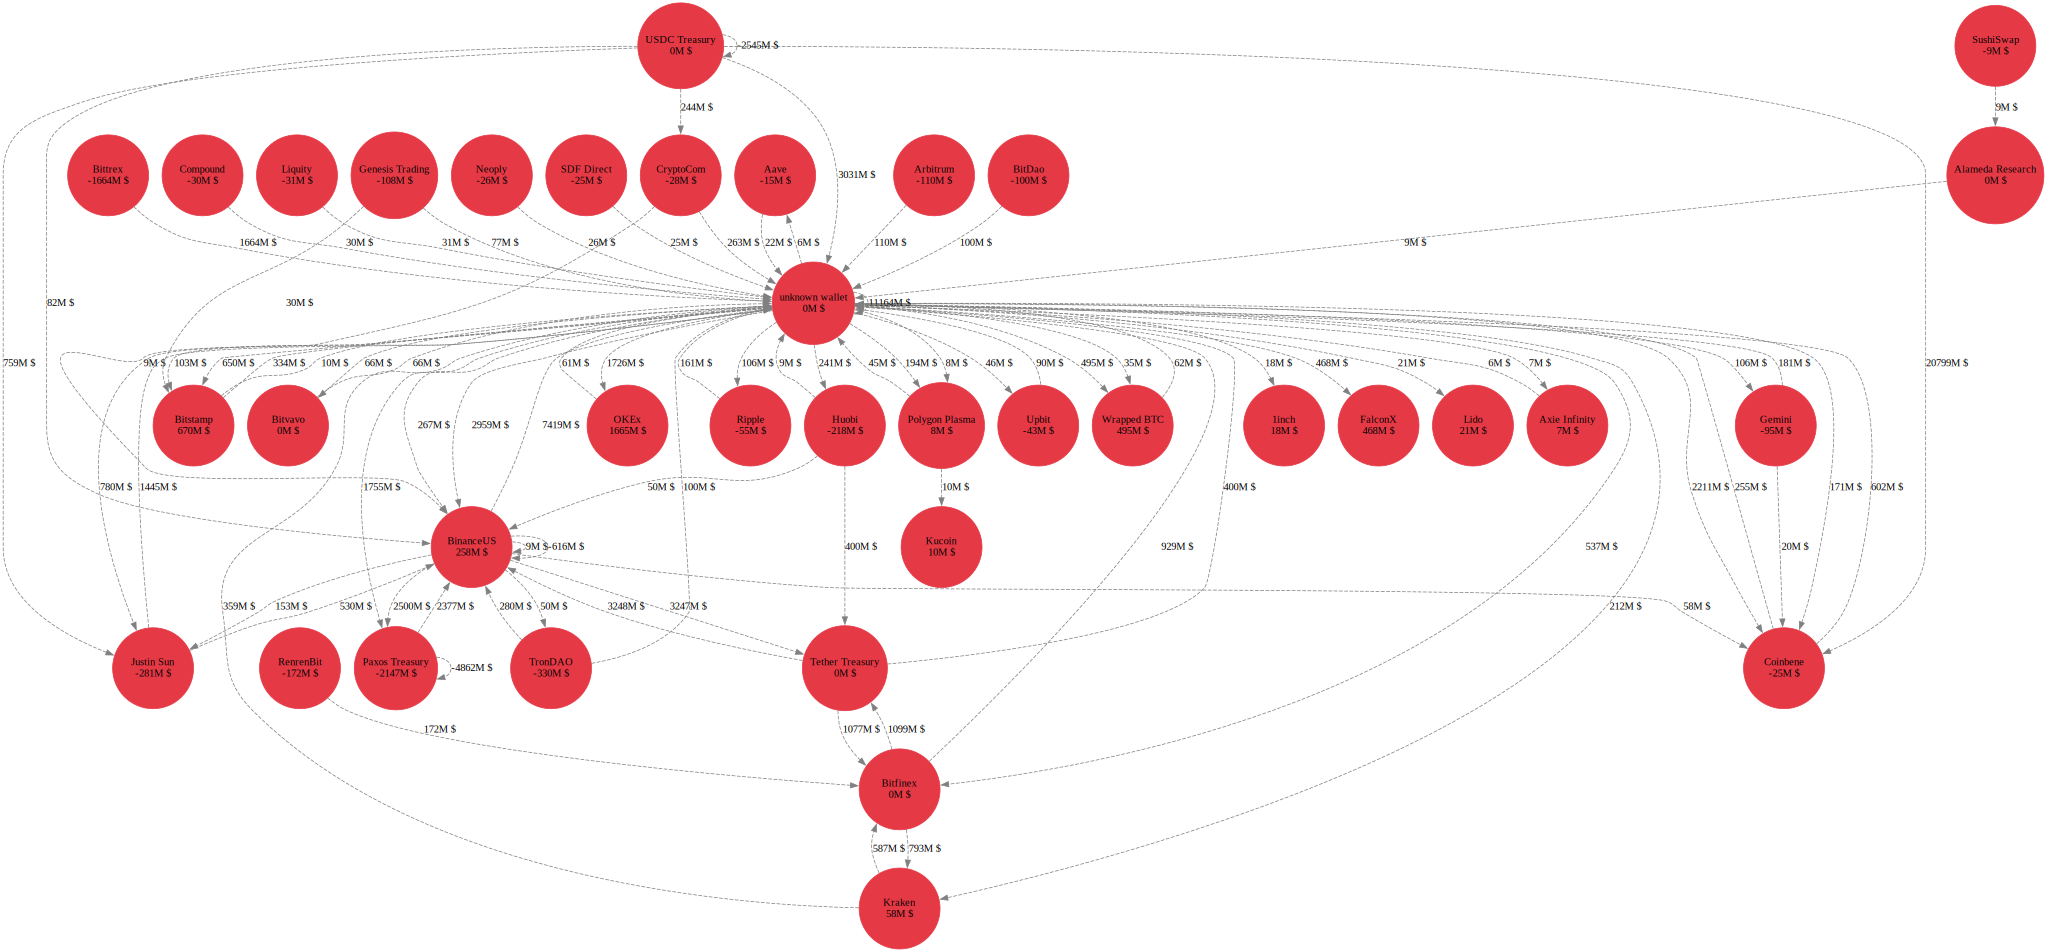

In [ ]:
dot